In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, vectorize

np.seterr(divide="ignore", invalid="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# 4.7 Common Mistakes

$$
S(x)=-ln(e^{-0.5x^2}+e^{-0.5(x-100)^2})
$$


In [3]:
sqrt = np.sqrt
π = np.pi
exp = np.exp
ln = np.log

In [4]:
@njit
def P(x):
    p1 = exp(-0.5 * x ** 2)
    p2 = exp(-0.5 * (x - 100) ** 2)
    return (p1 + p2) / (2 * sqrt(2 * π))


@njit
def S(x):
    return -ln(P(x))

# too small or too large step

In [5]:
@njit
def mcmc(S, K=10_000, step=0.5):
    dx_rand = np.random.rand(K)
    dx = (dx_rand - 0.5) * step * 2.0  # ±step
    metro_rand = np.random.rand(K)
    accept = np.full(K, False)
    x = np.full(K, np.nan)
    x[0] = 0.0

    for k in range(1, K):
        init = S(x[k - 1])
        x[k] = x[k - 1] + dx[k]  # new x
        fin = S(x[k])
        accept[k] = exp(init - fin) > metro_rand[k]  # metro test
        x[k] = x[k] if accept[k] else x[k - 1]

    return x, accept[:].sum() / K


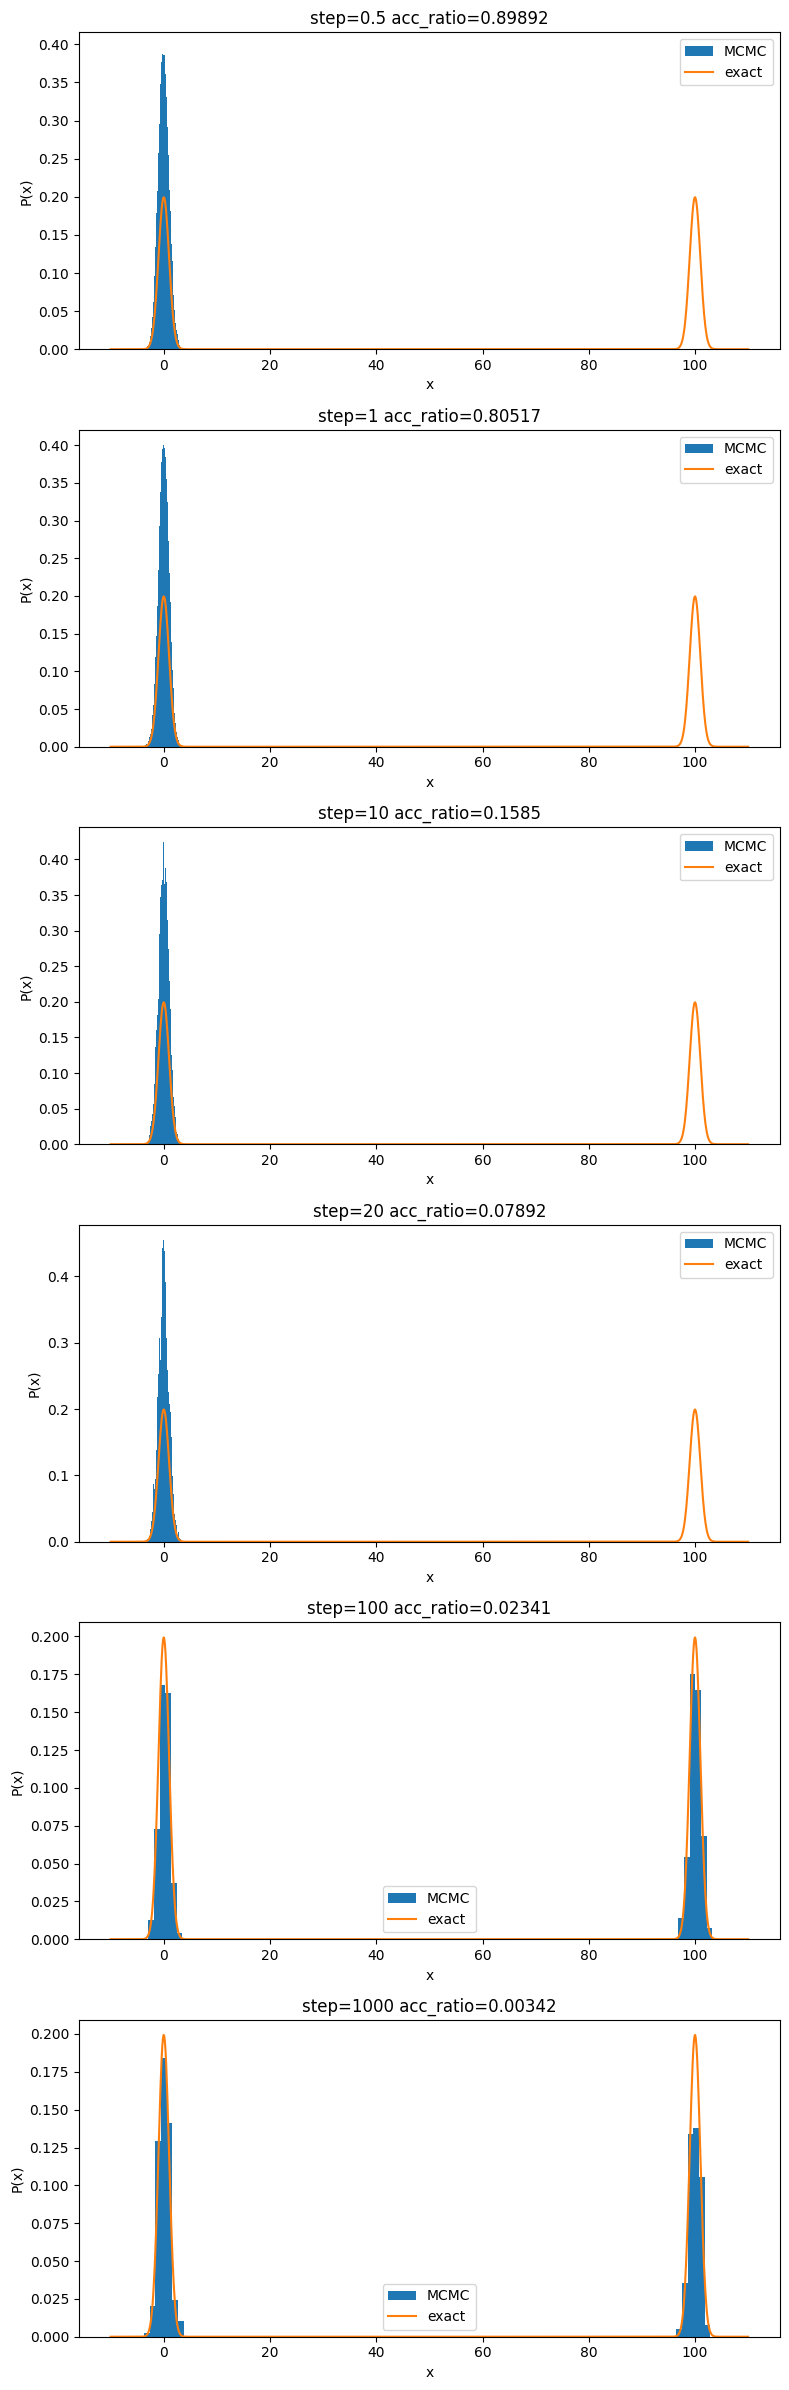

In [6]:
K = 100_000
steps = [0.5, 1, 10, 20, 100, 1000]
fig, axis = plt.subplots(
    len(steps),
    1,
    figsize=(8, len(steps) * 4),
    tight_layout=True,
)

x_exact = np.linspace(-10, 110, 1000)
y_exact = P(x_exact)

for step, ax in zip(steps, axis):
    x, acc_ratio = mcmc(S, K=K, step=step)

    ax.set(title=f"{step=} {acc_ratio=}", xlabel="x", ylabel="P(x)")

    ax.hist(x, 100, density=True, label="MCMC")
    ax.plot(x_exact, y_exact, label="exact")

    ax.legend()

# we know ahead what steps to use and alternate them

In [7]:
@njit
def mcmc_alt_step(S, K=10_000, step=[0.5, 100]):
    dx_rand = np.random.rand(K)
    dx = np.full_like(dx_rand, np.nan)
    dx[0::2] = (dx_rand[0::2] - 0.5) * step[0] * 2.0  # ±step 0.5
    dx[1::2] = (dx_rand[1::2] - 0.5) * step[1] * 2.0  # ±step 100
    metro_rand = np.random.rand(K)
    accept = np.full(K, False)
    x = np.full(K, np.nan)
    x[0] = 0.0

    for k in range(1, K):
        init = S(x[k - 1])
        x[k] = x[k - 1] + dx[k]  # new x
        fin = S(x[k])
        accept[k] = exp(init - fin) > metro_rand[k]  # metro test
        x[k] = x[k] if accept[k] else x[k - 1]

    return x, accept[:].sum() / K


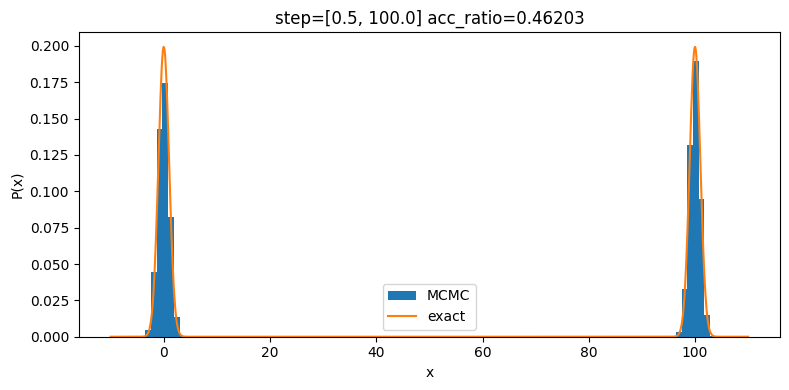

In [8]:
K = 100_000
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)

x_exact = np.linspace(-10, 110, 1000)
y_exact = P(x_exact)

step = [0.5, 100.0]
x, acc_ratio = mcmc_alt_step(S, K=K, step=step)

ax.set(title=f"{step=} {acc_ratio=}", xlabel="x", ylabel="P(x)")

ax.hist(x, 100, density=True, label="MCMC")
ax.plot(x_exact, y_exact, label="exact")

ax.legend();

# same as above but order of step size random

In [9]:
@njit
def mcmc_rand_step(S, K=10_000, step=[0.5, 10.0, 20.0, 100.0, 1000.0]):
    dx_rand = np.random.rand(K)
    dx_i = np.random.randint(0, len(step), len(dx_rand))
    dx = (dx_rand - 0.5) * step[dx_i] * 2.0  # ±step randomly from steps
    metro_rand = np.random.rand(K)
    accept = np.full(K, False)
    x = np.full(K, np.nan)
    x[0] = 0.0

    for k in range(1, K):
        init = S(x[k - 1])
        x[k] = x[k - 1] + dx[k]  # new x
        fin = S(x[k])
        accept[k] = exp(init - fin) > metro_rand[k]  # metro test
        x[k] = x[k] if accept[k] else x[k - 1]

    return x, accept[:].sum() / K


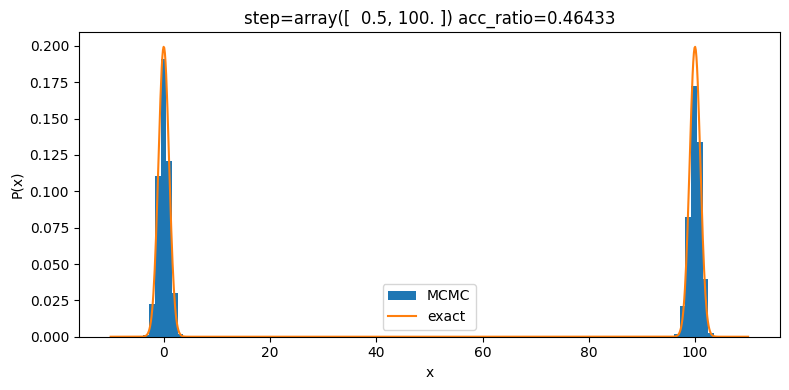

In [10]:
K = 100_000
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)

x_exact = np.linspace(-10, 110, 1000)
y_exact = P(x_exact)

step = np.array([0.5, 100])
x, acc_ratio = mcmc_rand_step(S, K=K, step=step)

ax.set(title=f"{step=} {acc_ratio=}", xlabel="x", ylabel="P(x)")

ax.hist(x, 100, density=True, label="MCMC")
ax.plot(x_exact, y_exact, label="exact")

ax.legend();

# "very bad not really random" seeds

$$
S(x)=-ln(e^{-0.5(x+2)^2}+e^{-0.5(x-2)^2})
$$


In [11]:
@njit
def P(x):
    p1 = exp(-0.5 * (x + 2) ** 2)
    p2 = exp(-0.5 * (x - 2) ** 2)
    return (p1 + p2) / (2 * sqrt(2 * π))


@njit
def S(x):
    return -ln(P(x))

In [25]:
@njit
def mcmc_repeat_rand(S, dx_rand, step=0.5):
    K = len(dx_rand)
    dx = (dx_rand - 0.5) * step * 2.0  # ±step
    metro_rand = np.random.rand(K)
    accept = np.full(K, False)
    x = np.full(K, np.nan)
    x[0] = 0.0

    for k in range(1, K):
        init = S(x[k - 1])
        x[k] = x[k - 1] + dx[k]  # new x
        fin = S(x[k])
        accept[k] = exp(init - fin) > metro_rand[k]  # metro test
        x[k] = x[k] if accept[k] else x[k - 1]

    return x, accept[:].sum() / K



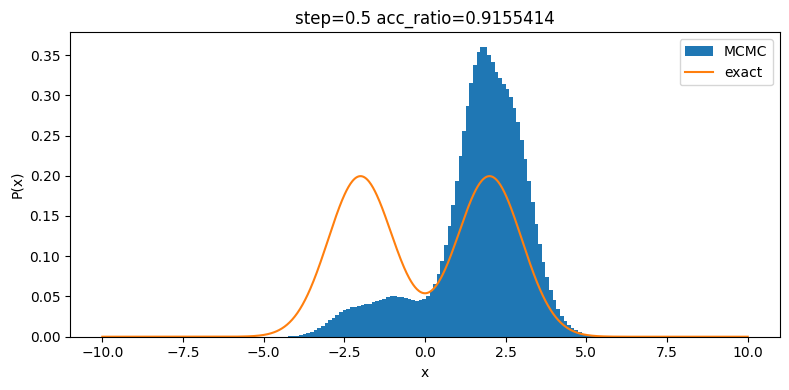

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)

x_exact = np.linspace(-10, 10, 1000)
y_exact = P(x_exact)

step = 0.5
K = 10_000_000
# repeat same random seed
dx_rand = np.tile(np.random.rand(1000), K//1000)
x, acc_ratio = mcmc_repeat_rand(S, dx_rand)

ax.set(title=f"{step=} {acc_ratio=}", xlabel="x", ylabel="P(x)")

ax.hist(x, 100, density=True, label="MCMC")
ax.plot(x_exact, y_exact, label="exact")

ax.legend();